# Lending Club Loan Data Analysis

Import R libraries:

In [2]:
library(dplyr)

library(lubridate)
library(ggplot2)
library(dplyr)
library(stringr)
library(caret)
library(rpart)
#library(rattle)
library(ROSE)
library(ROCR)
library(MASS)
library(ipred)
library(plyr)
library(rpart.plot)
require(gridExtra) # also loads grid

library(data.table)
options(datatable.print.nrows = 500)
options(width = 110)
options(repr.plot.width=11, repr.plot.height=5)

In [3]:
# Set working path:
wkdir = "/Users/qiaolinchen/Documents/LendingClub/"
raw_data_path = paste0(wkdir, 'raw_data/')

## 1.Load data from CSV files

In [4]:
df_2017Q1 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2017Q1.csv"))
df_2017Q2 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2017Q2.csv"))
df_2017Q3 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2017Q3.csv"))

df_2016Q1 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2016Q1.csv"))
df_2016Q2 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2016Q2.csv"))
df_2016Q3 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2016Q3.csv"))
df_2016Q4 = read.csv(paste0(raw_data_path, "LoanStats_securev1_2016Q4.csv"))

df_2015   = read.csv(paste0(raw_data_path, "LoanStats3d_securev1.csv"))
df_2014   = read.csv(paste0(raw_data_path, "LoanStats3c_securev1.csv"))
df_1213   = read.csv(paste0(raw_data_path, "LoanStats3b_securev1.csv"))
df_2011   = read.csv(paste0(raw_data_path, "LoanStats3a_securev1.csv"))

In [5]:
df_2016= rbind(df_2016Q1, df_2016Q2, df_2016Q3, df_2016Q4)
df_2017= rbind(df_2017Q1, df_2017Q2, df_2017Q3)

In [6]:
# Concatenate all data in to a big dataset
df_raw = rbind( df_2017, df_2016, df_2015,  df_2014,df_1213, df_2011 )
dim(df_raw)

[1] 1646781     151

In [7]:
# check missingness of columns removed
missing_pct <- function(df, type= 'pct'){
    na_count <-sapply(df, function(y) sum(length(which(is.na(y)))))
    if (type=='pct'){round( na_count/dim(df)[1] *100, digits=3)}
    else {na_count}
}                      
# check missing percentage           
#missing_pct(df_all)    

# define a function to show frequency including missing: 
table1 = function (..., useNA = 'ifany') base::table(..., useNA = useNA)

# define a function to count missing observation by year
missing_by_year = function( df = df1 , column ){
    aggregate(get(column) ~ Year, data= df, function(x) {sum(is.na(x))}, na.action = NULL)
}

## 2. Feature Engineering


### 2.1 Parse dates and compute date intervals
```R
parse_date = function(dt){
    # parse month-year as first day of the month
    as.character( as.Date(paste0('01-',dt) , "%d-%b-%y") )
}
parse_date('Mar-17')
date_list = c('issue_d', 'earliest_cr_line','last_pymnt_d')
# apply( head(df_all[date_list]),1:2, parse_date )

df_all[, date_list] = apply(df_all[, date_list] ,1:2, parse_date)
```

In [8]:
# make a copy
df_all= data.frame(df_raw)

In [9]:
df_all$issue_d          <- as.character(parse_date_time(df_all$issue_d          , "my"))
df_all$earliest_cr_line <- as.character(parse_date_time(df_all$earliest_cr_line , "my"))
df_all$next_pymnt_d     <- as.character(parse_date_time(df_all$next_pymnt_d     , "my"))
# 814989 failed to parse.
df_all$last_pymnt_d     <- as.character(parse_date_time(df_all$last_pymnt_d     , "my"))
# 1621 failed to parse

date_list = c('issue_d', 'earliest_cr_line','last_pymnt_d','next_pymnt_d')
df_all[1:5, date_list]

issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d
2017-03-01,1996-05-01,2017-12-01,2018-01-01
2017-03-01,2004-01-01,2017-12-01,2018-01-01
2017-03-01,2003-12-01,2017-12-01,2018-01-01
2017-03-01,1974-02-01,2017-12-01,2018-01-01
2017-03-01,1974-11-01,2017-12-01,2018-01-01


In [10]:
# Compute duration (days) from loan issue to last payment:
df_all[,'Year_issued'] = as.numeric(substr( df_all$issue_d ,1,4))
df_all[,'Month_issued'] = as.numeric(substr(df_all$issue_d ,6,7))

In [11]:
# Credit history days before loan issued
df_all[,'credit_days'] = as.numeric(as.Date(df_all$issue_d) - as.Date(df_all$earliest_cr_line) )
# impute missing credit days to 0:
df_all[is.na(df_all$credit_days),'credit_days'] = 0

# days since loan issued
df_all[,'Days'] = as.numeric(as.Date(df_all$last_pymnt_d) - as.Date( df_all$issue_d) )

In [12]:
missing_pct(df_all[, c(date_list,'credit_days', 'Days')])
#head(df_all[c('Year_issued', 'Month_issued','issue_d','earliest_cr_line','last_pymnt_d','credit_days','Days')])

issue_d earliest_cr_line     last_pymnt_d     next_pymnt_d      credit_days             Days 
           0.000            0.002            0.098           49.490            0.000            0.098

In [13]:
# Converting few relevant columns as factors
factor_list = c( 'id', 'grade', 'sub_grade', 'home_ownership', 'emp_length', 'verification_status',
                'pymnt_plan',  'application_type', 'loan_status', 'policy_code', 'initial_list_status','purpose', 
                'title', 'addr_state', 'term')

# check if column names all valid
factor_list %in% colnames(df_all)

tmp=  head(df_all[,factor_list], 10)
for (col in factor_list){
    df_all[, col] = as.factor( df_all[, col] )
}

#str(df_all)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

### 2.2 Combine loan status into fewer groups

In [14]:
round(table(df_all$loan_status)/dim(df_all)[1]*100,2)


                                        Charged Off                                             Current 
                                              10.21                                               47.91 
                                            Default                                          Fully Paid 
                                               0.00                                               39.28 
                                    In Grace Period                                   Late (16-30 days) 
                                               0.64                                                0.35 
                                 Late (31-120 days)                                                     
                                               1.44                                                0.00 
Does not meet the credit policy. Status:Charged Off  Does not meet the credit policy. Status:Fully Paid 
                                               0.05   

In [15]:
df_all[,'Loan_Status'] = ''
df_all[df_all[,'loan_status'] %in% c('In Grace Period','Late (16-30 days)','Late (31-120 days)') ,'Loan_Status'] = 'Late'
df_all[df_all[,'loan_status'] %in% c('Charged Off','Default') ,'Loan_Status'] = 'Default'
df_all[df_all[,'loan_status'] %in% c('Does not meet the credit policy. Status:Charged Off',
                                     'Does not meet the credit policy. Status:Fully Paid') ,'Loan_Status'] = NA
df_all[df_all[,'loan_status'] == 'Current', 'Loan_Status'] = 'Current'
df_all[df_all[,'loan_status'] == 'Fully Paid', 'Loan_Status'] = 'Fully Paid'
df_all[df_all[,'loan_status'] == '', 'Loan_Status'] = NA

In [21]:
table(df_all[,'Loan_Status'])
sum(is.na(df_all[,'Loan_Status']))


   Current    Default Fully Paid       Late 
    788950     168154     646902      40023 

[1] 2752

### Add target variables for survival analysis
- time to event
- Default/ charge off
- full paid

In [22]:
df_all[,'Default'] = df_all[,'loan_status']  %in% c('Default','Charged Off')
df_all[,'Fully_paid'] = df_all[,'loan_status']  %in% c('Fully_paid')

In [23]:
df_all = df_all[order(df_all$issue_d),]

In [20]:
remove_pct = function(x){
    as.numeric(substr(x,1,nchar(x)-1))
}
remove_pct('15.99%')

pct_list = c('int_rate','revol_util')
df_all[, pct_list] = apply(df_all[, pct_list] ,1:2, remove_pct)

[1] 15.99

In [24]:
df_all[, 'zip3d'] =  substr(df_all[ , 'zip_code'],1,3 ) 

In [25]:
df_all[, 'zipcode'] = paste0( substr(df_all[ , 'zip_code'],1,3 ), "01")
head(df_all[, 'zipcode'] )

[1] "02701" "06501" "08701" "78701" "07801" "65201"

Use zipcode table to match to city:

In [27]:
zip_city = read.csv(paste0(raw_data_path, "3-digit_zip_code.csv"))

zip_city$nchar     = apply(matrix(zip_city$City), c(1,2), nchar)
zip_city$zip3d   = substr(zip_city$City, zip_city$nchar -2, zip_city$nchar )
zip_city$city      = substr(zip_city$City, 1, zip_city$nchar -7)
#zip_city$city_state = paste(zip_city$city, substr(zip_city$City, zip_city$nchar -5, zip_city$nchar -4), sep= ',')

drops <- c("City","zip", 'nchar')
zip_city = zip_city[ , !(names(zip_city) %in% drops)]
head(zip_city)

zip3d,city
005,MID-ISLAND
006,SAN JUAN
007,SAN JUAN
008,SAN JUAN
009,SAN JUAN
010,HARTFORD


In [28]:
df_all = merge( df_all, zip_city, by ='zip3d', all.x = TRUE)

## Exclude some columns
Exclude columns with > 97% missing, happened after loan default, or are almost the same as other existing columns:


In [29]:
join_applicant_info = c( 'settlement_term', 'annual_inc_joint','dti_joint','revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
                'sec_app_earliest_cr_line' ,'sec_app_inq_last_6mths' ,'sec_app_mort_acc' ,'sec_app_open_acc',
                'sec_app_revol_util', 'sec_app_open_act_il' ,'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
                'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog')

duplicate_variables = c('funded_amnt', 'funded_amnt_inv','last_credit_pull_d','next_pymnt_d')
# potential target leaks
hardship_settlement = c('member_id','hardship_flag', 'hardship_type',
                'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date',
                'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status',
                'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
                'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status',
                'settlement_date', 'settlement_amount', 'settlement_percentage')
col_exclude= c(join_applicant_info, duplicate_variables, hardship_settlement)

# check missingness of columns removed
missing_pct <- function(df){
    na_count <-sapply(df, function(y) sum(length(which(is.na(y)))))
    tmp=round( na_count/dim(df)[1] *100, digits=2)
}
                      
# check missing percentage           
#missing_pct(df_all[, col_exclude])    

### Exclude some loan records
Exclude loan records with data issue: 
1. loan amount missing 
2. status is "Does not meet the credit policy. Status:Charged Off" or "Does not meet the credit policy. Status:Fully paid". This population is different from the population we are interested in modeling.
3. Last payment date (last_pymnt_d) is not missing. These records are not valid for future time to event modeling.

In [30]:
#tmp= df1[is.na(df1$Days), c('loan_amnt','revol_bal','Days','issue_d' ,'last_pymnt_d','next_pymnt_d','loan_status')]
df1= df_all[ df_all$loan_amnt >0 , !(names(df_all) %in% col_exclude)]
df1 = df1[!is.na(df1$Loan_Status),  ]    # remove 2752 records
df1 = df1[!is.na(df1$last_pymnt_d),  ]   # remove 1606 records

## Missing data imputation
Many of the missing values for this dataset is not missing at random, but have special meanings. 
Columns containing missing values can be grouped into different groups and use different methods to do imputation:
- Text
    - desc: missing -> ''

- impute to maximum: 
    - mths_since_last_delinq, mo_sin_old_il_acct
- Remove if the variable is almost a duplicate of other existing varialbes: 
    - 'next_pymnt_d','verification_status_joint', 
- impute using median or knn: dti, 'il_util'



In [31]:
# Loan description provided by the borrower
df1[is.na(df1$desc), 'desc'] = ''

levels(df1[,'verification_status_joint']) <- c(levels(df1[,'verification_status_joint']),"Missing")
df1[is.na(df1$verification_status_joint), 'verification_status_joint'] = 'Missing'

In [37]:
# impute using median

# pct_tl_nvr_dlq	Percent of trades never delinquent
# bc_open_to_buy	Total open to buy on revolving bankcards.
# bc_util	Ratio of total current balance to high credit/credit limit for all bankcard accounts.
# percent_bc_gt_75	Percentage of all bankcard accounts > 75% of limit.
# mths_since_recent_bc	Months since most recent bankcard account opened.
# num_tl_120dpd_2m	Number of accounts currently 120 days past due (updated in past 2 months)
# mo_sin_old_il_acct	Months since oldest bank installment account opened
#- mths_since_recent_inq	Months since most recent inquiry.

col_list = c('pct_tl_nvr_dlq', 'bc_open_to_buy','bc_util','percent_bc_gt_75',  'mths_since_recent_bc',
             'num_tl_120dpd_2m','mo_sin_old_il_acct', 'mths_since_recent_inq')

for (col in col_list){
    print(paste0(col, ': missing %= ', round(sum(is.na(df1[, col]))/dim(df1)[1]*100, digits=2 )) )
    df1[is.na(df1[, col]), col ] = median( df1[, col], na.rm =T)  # this is impute using median
}

# if impute using kNN 
#library(VIM)
#df1[ , col_list] = kNN(df1[ , col_list],imp_var = FALSE) 


[1] "pct_tl_nvr_dlq: missing %= 4.11"
[1] "bc_open_to_buy: missing %= 3.87"
[1] "bc_util: missing %= 3.92"
[1] "percent_bc_gt_75: missing %= 3.9"
[1] "mths_since_recent_bc: missing %= 3.81"
[1] "num_tl_120dpd_2m: missing %= 8.01"
[1] "mo_sin_old_il_acct: missing %= 6.9"
[1] "mths_since_recent_inq: missing %= 13.17"


In [33]:
# Impute using a large number 

# These variables are missing be cause deliquency/public record/worse rating never happened. 
# A set of new missing indicator variables should be created,
# if we want to do imputation, the time since these events should be imputed to a very long time, say 200 months (~17 years). 

# mths_since_last_delinq	The number of months since the borrower's last delinquency.
# mths_since_last_record	The number of months since the last public record.
# mths_since_last_major_derog	Months since most recent 90-day or worse rating
# mths_since_recent_bc_dlq	Months since most recent bankcard delinquency
# mths_since_recent_revol_delinq	Months since most recent revolving delinquency.

col_list= c('mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog',
           'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq')
for (col in col_list){
    print(paste0(col, ': missing %= ', round(sum(is.na(df1[, col]))/dim(df1)[1]*100, digits=2 )) )
    print( paste0( 'Max value= ', max( df1[, col], na.rm =T)) )
    df1[, paste0(col,'_miss')] = is.na(df1[, col])
    df1[is.na(df1[, col]), col ] = 200
}

[1] "mths_since_last_delinq: missing %= 49.62"
[1] "Max value= 195"
[1] "mths_since_last_record: missing %= 83.13"
[1] "Max value= 129"
[1] "mths_since_last_major_derog: missing %= 73.43"
[1] "Max value= 197"
[1] "mths_since_recent_bc_dlq: missing %= 75.84"
[1] "Max value= 195"
[1] "mths_since_recent_revol_delinq: missing %= 65.79"
[1] "Max value= 197"


In [34]:
tmp16 = missing_pct(df1[df1$Year >= 2016, ])
tmp15 = missing_pct(df1[df1$Year == 2015, ])
tmp14 = missing_pct(df1[df1$Year == 2014, ])
tmp13 = missing_pct(df1[df1$Year == 2013, ])
tmp12 = missing_pct(df1[df1$Year == 2012, ])

In [35]:
tmp = data.frame(cbind(tmp16, tmp15, tmp14, tmp13, tmp12))
tmp[tmp$tmp16 > 1, ]
#tmp[(tmp$tmp16 <= 1) & (tmp$tmp15 > 0.01) , ]
#tmp[(tmp$tmp15 <= 0.01) & (tmp$tmp14 > 0.01) , ]
#tmp[(tmp$tmp14 <= 0.01) & (tmp$tmp13 > 0.01) , ]
#tmp[(tmp$tmp13 <= 0.01) & (tmp$tmp12 > 0.01) , ]

,tmp16,tmp15,tmp14,tmp13,tmp12
mths_since_rcnt_il,2.70,95.06,100.00,100.00,100.00
il_util,13.24,95.58,100.00,100.00,100.00
bc_open_to_buy,1.12,0.94,1.03,0.74,15.01
bc_util,1.16,1.00,1.10,0.79,15.06
mo_sin_old_il_acct,2.69,2.91,3.04,3.67,54.18
mths_since_recent_bc,1.06,0.90,0.95,0.65,14.88
mths_since_recent_inq,10.88,10.59,9.21,10.82,24.89
num_tl_120dpd_2m,4.85,4.57,3.34,0.19,51.98
percent_bc_gt_75,1.12,1.01,1.08,0.75,15.01


In [36]:
list_1617_only = c( 'revol_util','open_acc_6m','open_act_il','open_il_12m','open_il_24m',
            'open_rv_12m','open_rv_24m', 'total_bal_il','max_bal_bc','all_util','inq_fi','inq_last_12m','total_cu_tl',
                  'mths_since_rcnt_il', 'il_util')
# il_util: Ratio of total current balance to high credit/credit limit on all install acct

# open_acc_6m	Number of open trades in last 6 months
# open_act_il	Number of currently active installment trades
# open_il_12m	Number of installment accounts opened in past 12 months
# open_il_24m	Number of installment accounts opened in past 24 months
# open_rv_12m	Number of revolving trades opened in past 12 months
# open_rv_24m	Number of revolving trades opened in past 24 months
# total_bal_il	Total current balance of all installment accounts
# max_bal_bc	Maximum current balance owed on all revolving accounts
# all_util	Balance to credit limit on all trades
# inq_fi	Number of personal finance inquiries
# inq_last_12m	Number of credit inquiries in past 12 months
# total_cu_tl	Number of finance trades
# mths_since_rcnt_il	Months since most recent installment accounts opened
# il_util	Ratio of total current balance to high credit/credit limit on all install acct

In [40]:
# Create a subset of loans issued 2016-2017
df_2016_2017 = df1[df1$Year>= 2016, ]
dim( df_2016_2017)
# impute missing values with median
for (col in list_1617_only){
    print(paste0(col, ': missing %= ', round(sum(is.na(df_2016_2017[, col]))/dim(df_2016_2017)[1]*100, digits=2 )) )
    df_2016_2017[is.na(df_2016_2017[, col]), col ] = median( df_2016_2017[, col], na.rm =T)  # this is impute using median
}

[1] 758390    123

[1] "revol_util: missing %= 0.07"
[1] "open_acc_6m: missing %= 0.01"
[1] "open_act_il: missing %= 0.01"
[1] "open_il_12m: missing %= 0.01"
[1] "open_il_24m: missing %= 0.01"
[1] "open_rv_12m: missing %= 0.01"
[1] "open_rv_24m: missing %= 0.01"
[1] "total_bal_il: missing %= 0.01"
[1] "max_bal_bc: missing %= 0.01"
[1] "all_util: missing %= 0.02"
[1] "inq_fi: missing %= 0.01"
[1] "inq_last_12m: missing %= 0.01"
[1] "total_cu_tl: missing %= 0.01"
[1] "mths_since_rcnt_il: missing %= 2.7"
[1] "il_util: missing %= 13.24"


In [ ]:
drop_list = c('zip3d', 'id', 'url', 'zip_code' )

In [ ]:
drop_from_model = c('issue_d', 'loan_status','out_prncp', 'out_prncp_inv',   'total_rec_prncp', 
                    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                   'last_pymnt_d', 'last_pymnt_amnt', 'Loan_Status', 'fully_paid', 'year_issued' )

In [527]:
dim(df1[df1$Year>= 2016, ])

[1] 758390    124

### Save datasets to CSV files

In [44]:
dim(df_all)

[1] 1646781     161

In [41]:
df_paid_chargeOff = df1[df1$loan_status %in% c('Fully Paid','Charged Off') ,]
dim(df_paid_chargeOff )
write.csv(df_paid_chargeOff, file= paste0(wkdir ,'loan_paid_chargeOff.csv') )

[1] 813517    123

In [42]:
df_sample = df_paid_chargeOff[sample(nrow(df_paid_chargeOff), 200000), ]
dim(df_sample)
write.csv(df_sample, file= paste0(wkdir ,'loan_200K.csv') )

[1] 200000    123

In [43]:
dim(df_2016_2017)
write.csv(df_2016_2017, file= paste0(wkdir ,'loan_2016-2017.csv') )

[1] 758390    123

## Exploratory Data Analysis


### Loan status over time

In [57]:
plot_over_time = function(col ='Loan_Status'){
    options(repr.plot.width=11, repr.plot.height=5)
    count = table( df_all$Year, df_all[,col]  )
    counts = melt( count ) 
    colnames(counts) = c('Year', col ,'Frequency')

    pct = melt( round( count/ apply( count,1,sum) *100 ,digits= 2) )
    colnames(pct) = c('Year', col ,'Percentage')

    p1 = ggplot(data= counts, aes(x= as.factor(Year), y= Frequency, group= get(col) , colour= get(col) )) +
        geom_line() + geom_point() +ggtitle(paste0('Frequency of Loans by ', col,' Over Time') )

    p2 = ggplot(data= pct, aes(x= as.factor(Year), y= Percentage, group= get(col) , colour= get(col) )) +
        geom_line() + geom_point() +ggtitle(paste0('Percentage of Loans by ', col,' Over Time') )

    grid.arrange(p1, p2, ncol=2)
}

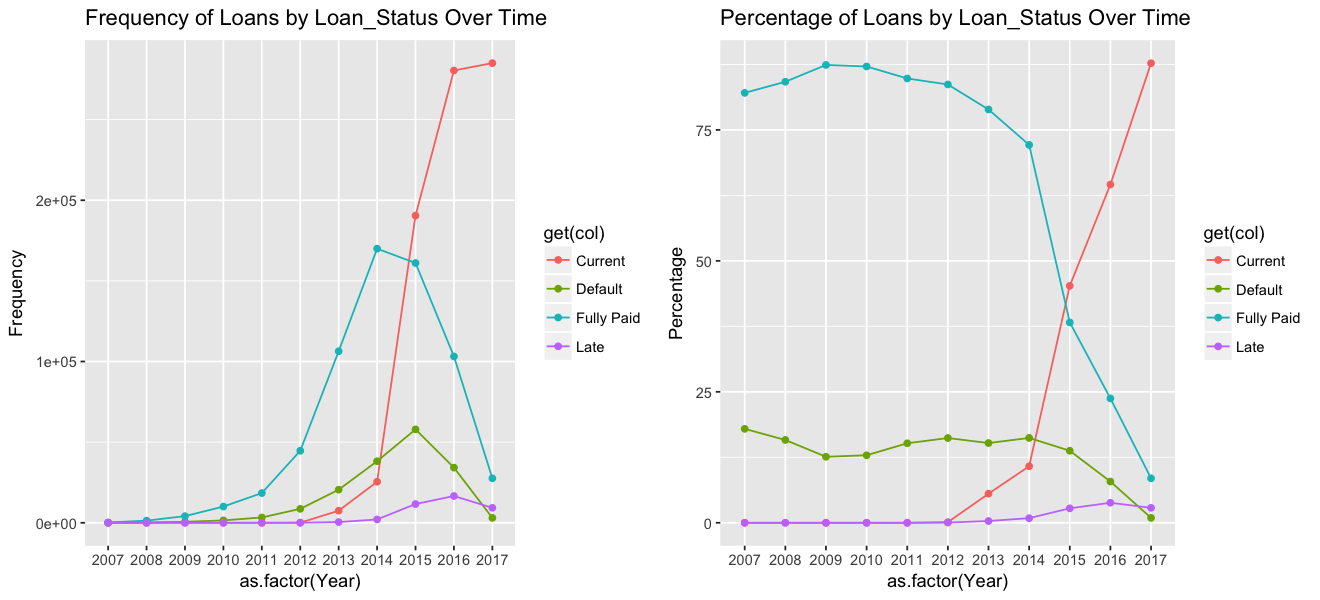

In [58]:
plot_over_time(col= 'Loan_Status')

In [59]:
table(df_all$Loan_Status, df_all$grade)

            
                  A      B      C      D      E      F      G       
  Current    137090 241574 250558 100484  42930  12191   4123      0
  Default      8705  31746  50693  38958  24748  10389   2915      0
  Fully Paid 124771 203493 175253  88722  38817  12728   3118      0
  Late         2060   8193  13651   8657   4930   1856    676      0

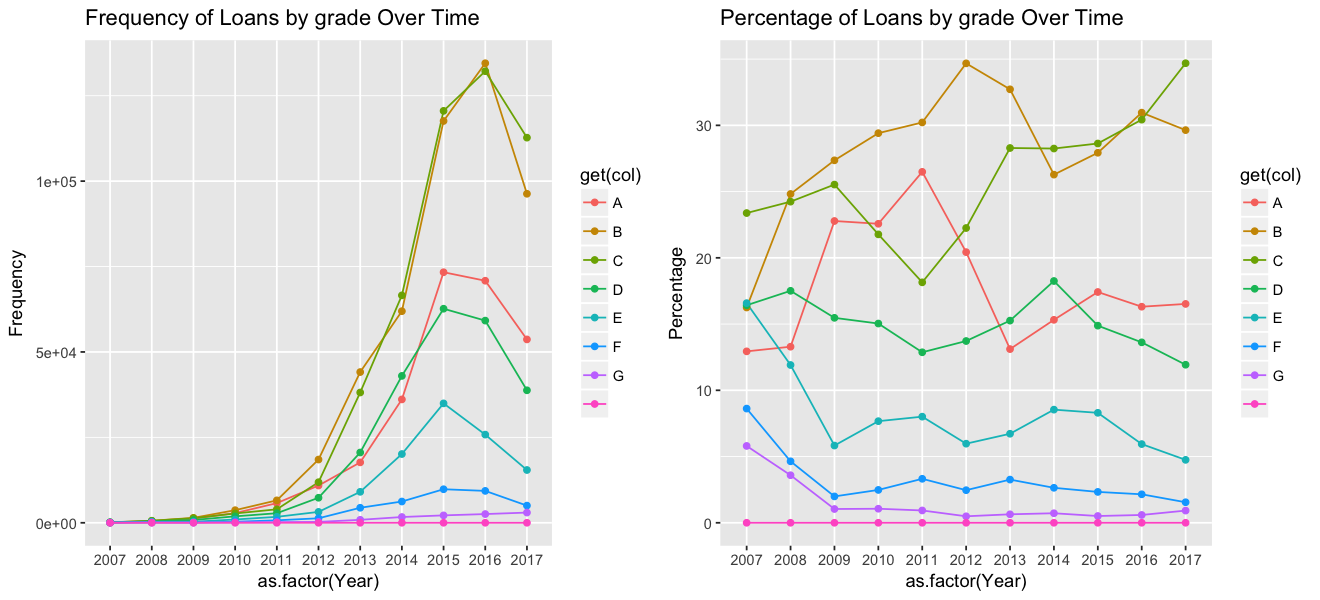

In [60]:
plot_over_time(col= 'grade')